In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import glob
from torchvision.io import read_image
import torchvision.transforms.functional as func
import torch.optim as optim

In [3]:
from PIL import Image
import os, sys

path = "data/Raphael/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.ANTIALIAS)
            imResize.save("data/resized", 'JPEG', quality=90)

resize()

In [5]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0
0.12.0


In [236]:
# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()

#         # 28x28x1 => 26x26x32
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1)
#         self.d1 = nn.Linear(26 * 26 * 32, 128)
#         self.d2 = nn.Linear(128, 10)

#     def forward(self, x):
#         # 32x1x28x28 => 32x32x26x26
#         x = self.conv1(x)
#         x = F.relu(x)

#         # flatten => 32 x (32*26*26)
#         x = x.flatten(start_dim = 1)
#         print(x.shape)
#         # 32 x (32*26*26) => 32x128
#         x = self.d1(x)
#         x = F.relu(x)

#         # logits => 32x10
#         logits = self.d2(x)
#         out = F.softmax(logits, dim=1)
#         return out

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1),
            nn.ReLU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1),
            nn.ReLU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3,padding=1),
        )

    def forward(self, x):
        print("x.shape", x.shape)
        embed = self.encoder(x)
        print("embed.shape", embed.shape)
        decoded = self.decoder(embed)
        print("decoded.shape", decoded.shape)
        spatial_size_of_x = x.shape[-2:]
        decoded_resized = F.interpolate(decoded, size=spatial_size_of_x, mode='bilinear')
        print("decoded_resized.shape", decoded_resized.shape)

        return decoded_resized

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
class CustomDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.img_paths = [path for path in glob.glob(main_dir+"*.jpg", recursive=True)]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        return self.preprocess(index)

    def preprocess(self, index) -> Tuple:
        # if index < 0:
        #     index = 0
        # if index >= len(self):
        #     index = len(self)-1
        image = read_image(self.img_paths[index])
        if self.transform:
            image = self.transform(image)
        # print(image.type())
        # image = image.float()
        image = func.resize(image, [28,28])
        # print(image)
        # print(image.type())
        # image = image.float()
        # print(image.type())
        # image = Tensor.float(image)
        # print(image.size())
        # rgb_weights=[0.2989, 0.5870, 0.1140]
        
        # image = 0.289 * image[:,2, :, :] + 0.587 * image[1, :,:] + 0.114 * image[0, :,:]
        # print(image.size())
        return (image,index)

1.11.0
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
batch size: torch.Size([32, 1, 28, 28])
x.shape torch.Size([32, 1, 28, 28])
embed.shape torch.Size([32, 32, 3, 3])
decoded.shape torch.Size([32, 1, 24, 24])
decoded_resized.shape torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


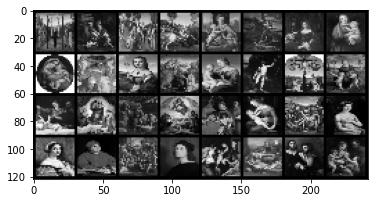

In [17]:


## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

if __name__=="__main__":
    print(torch.__version__)
    BATCH_SIZE = 32

    ## transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor()])
        # transforms.Grayscale()])
        # transforms.Normalize(img_mean, img_std),)

    ## download and load training dataset
    training_data = CustomDataset("data/Raphael/",transform=transform)
    trainloader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=0)

    ## download and load testing dataset
    testset = training_data = CustomDataset("data/Raphael/",transform=ToTensor())
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=0)
    ## get some random training images
    # model
    for images, labels in trainloader:
        print("Image batch dimensions:", images.shape)
        print("Image label dimensions:", labels.shape)
        break
    imshow(torchvision.utils.make_grid(images))
    model = MyModel()
    for images, labels in trainloader:
        print("batch size:", images.shape)
        out = model(images)
        print(out.shape)
        break

        ## show images
    

In [12]:
if __name__=="__main__":
    criterion = nn.CrossEntropyLoss()
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [14]:
learning_rate = 0.001
num_epochs = 5
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

True


In [15]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [16]:
model = MyModel()
model.cuda()
# for images, labels in trainloader:
#     print("batch size:", images.shape)
#     out = model(images)
#     print(out.shape)
#     break
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        # images, labels = images.cuda(), labels.cuda()
        images = images.float()
        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

x.shape torch.Size([32, 1, 28, 28])
embed.shape torch.Size([32, 32, 3, 3])
decoded.shape torch.Size([32, 1, 24, 24])
decoded_resized.shape torch.Size([32, 1, 28, 28])


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [32]

In [12]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.24
